In [32]:
import os
import sys
import xarray as xr
import dask
import matplotlib.pyplot as plt
import numpy as np
import cmocean.cm as ocm
from matplotlib import rcParams

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from visualization.shiftedColorMap import shiftedColorMap
from tools.calc_antarctic_mass_loss import calc_antarctic_mass_loss

In [52]:
from dask.distributed import Client
C = Client()
C

Client Scheduler: tcp://127.0.0.1:57757 Dashboard: http://127.0.0.1:45165/status,Cluster Workers: 16 Cores: 16 Memory: 101.38 GB


In [2]:
waom10_avg_path = os.path.join(data_dir,'raw','waom10_M3','ocean_avg_0009.nc')
avg10 = xr.open_mfdataset(waom10_avg_path)

waom10_grd_path = os.path.join(data_dir,'raw','waom_frc','waom10_grd.nc')
grd10 = xr.open_mfdataset(waom10_grd_path)

In [3]:
waom4_his_path = os.path.join(data_dir,'raw','waom4','ocean_avg_0009.nc')
avg4 = xr.open_mfdataset(waom4_his_path)

waom4_grd_path = os.path.join(data_dir,'raw','waom_frc','waom4_grd.nc')
grd4 = xr.open_mfdataset(waom4_grd_path)

In [4]:
waom2_his_path = os.path.join(data_dir,'raw','waom2_fix','m.nc')
avg2 = xr.open_mfdataset(waom2_his_path)

waom2_grd_path = os.path.join(data_dir,'raw','waom_frc','waom2_grd.nc')
grd2 = xr.open_mfdataset(waom2_grd_path)

In [5]:
from scipy.interpolate import griddata

def regrid(sgrd,sda,tgrd):
    
#tamura comes from npstereo curvilinear grid
#we need to find points close to the 0/360 gap, wrap them and add them to the list for source points
# otherwise we get an interpolation gap between 0/360
    slon = sgrd.lon_rho.values.flatten()
    slat = sgrd.lat_rho.values.flatten()
    sdat = sda.values.flatten()
    tlon=tgrd.lon_rho.values
    tlat=tgrd.lat_rho.values

    tdat =griddata((slon,slat),sdat,(tlon,tlat),'linear')
    tda = xr.DataArray(tdat,dims=['eta_rho','xi_rho'])
    
    return tda

In [6]:
temp_4 = regrid(grd4,avg4.temp.isel(s_rho=0).mean('ocean_time'),grd10)
temp_10to4 = temp_4 - avg10.temp.isel(s_rho=0).mean('ocean_time')

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [7]:
def plot_ismr_temp_map(m,temp,grd,title_str,m_min=-1,m_max=1,t_min=-1,t_max=1,out_path=None):

    s2a = 3600*24*365.25
    mask = (grd.zice < 0.0)&(grd.mask_rho==1)
    
    land_zice = (grd.mask_rho==0) | (grd.zice < 0.0)
    
    plt.close()
    fig,ax = plt.subplots(figsize=(15,8))
    ax.contourf(grd.mask_rho.where(land_zice).values[1:-1,1:-1],colors=(('0.6','0.6','0.6')))
    (m.where(mask)*s2a)[1:-1,1:-1].plot(vmin=m_min,vmax=m_max,ax=ax,cmap=plt.cm.seismic,cbar_kwargs={'label':'melt rate difference in m/yr'})
    temp.where(~land_zice)[1:-1,1:-1].plot(vmin=t_min,vmax=t_max,ax=ax,cmap=ocm.balance,cbar_kwargs={'label':'temperature difference  in degC'})
    ax.contour(-grd.zice.where(grd.mask_rho).values[1:-1,1:-1], levels=['0.01'], colors=('black'),linewidths=0.5)
    ax.contour(grd.mask_rho.values, levels=['0.01'], colors=('black'),linewidths=0.5)
    plt.title('Difference in basal melting and bottom layer temperature \n'+title_str, fontsize=20)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path)
    plt.show()

In [33]:
def plot_temp_map(temp,grd,title_str,t_min=-1,t_max=1,out_path=None):

    mask = (grd.zice < 0.0)&(grd.mask_rho==1)
    
    land = (grd.mask_rho==0)
    rcParams.update({'font.size': 18})
    plt.close()
    fig,ax = plt.subplots(figsize=(15,8))
    ax.contourf(grd.mask_rho.where(land).values[1:-1,1:-1],colors=(('0.6','0.6','0.6')))
    temp.where(~land)[1:-1,1:-1].plot(vmin=t_min,vmax=t_max,ax=ax,cmap=ocm.balance,cbar_kwargs={'label':'temperature difference  in degC'})
    ax.contour(-grd.zice.where(grd.mask_rho).values[1:-1,1:-1], levels=['0.01'], colors=('black'),linewidths=0.5)
    ax.contour(grd.mask_rho.values, levels=['0.01'], colors=('black'),linewidths=0.5)
    plt.title('Difference in bottom layer temperature \n'+title_str, fontsize=20)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path,format='png',dpi=300)
    plt.show()

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


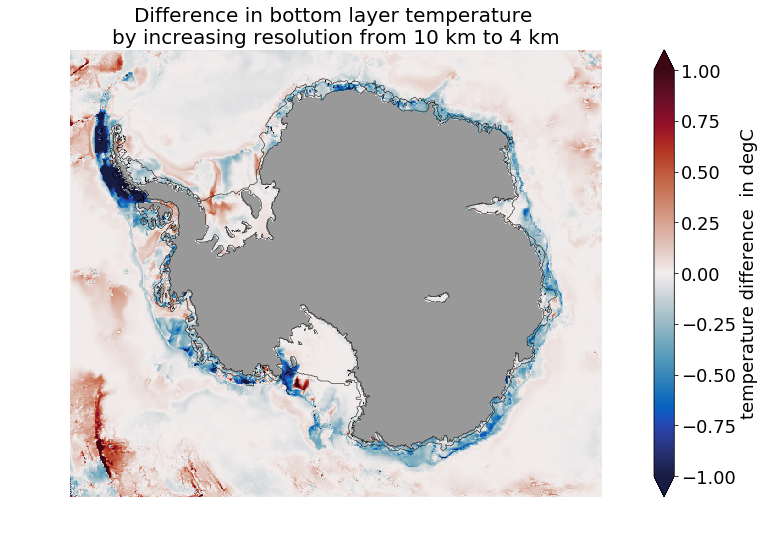

In [34]:
%matplotlib inline
out_path = os.path.join(proj_dir,'reports','figures','10to4Temp.png')
plot_temp_map(temp_10to4,grd10,'by increasing resolution from 10 km to 4 km')

In [ ]:
def plot_ismr_temp_diff_map(avg_from,avg_to,grd,m_min=-1,m_max=1,p_min=-1000,p_max=1000,out_path=None):

    s2a = 3600*24*365.25
    mask = (grd.zice < 0.0)&(grd.mask_rho==1)
    land_zice = (grd.mask_rho==0) | (grd.zice < 0.0)

    m_diff = (m_to-m_from)*s2a
    m_diff_rel = (m_to-m_from)/m_from*100

    plt.close()
    fig,axes = plt.subplots(ncols=2,figsize=(20,8))
    ax1,ax2 = axes.flatten()
    for ax in axes:
        ax.contourf(grd.mask_rho.where(land_zice).values,colors=(('0.6','0.6','0.6')))
        ax.contour(-grd.zice.where(grd.mask_rho).values, levels=['0.01'], colors=('black'),linewidths=0.5)
        ax.contour(grd.mask_rho.values, levels=['0.01'], colors=('black'),linewidths=0.5)
        ax.set_aspect('equal')
        ax.axis('off')


    (m_diff.where(mask).mean('ocean_time')).plot(vmin=m_min,vmax=m_max,ax=ax1,cmap=plt.cm.seismic)
    temp.where(~land_zice)[1:-1,1:-1].plot(vmin=t_min,vmax=t_max,ax=ax,cmap=ocm.balance,cbar_kwargs={'label':'temperature difference  in degC'})
    ax1.set_title('Melt rate difference (m/y), annual average', fontsize=20)
    (m_diff_rel.where(mask).mean('ocean_time')).plot(vmin=p_min,vmax=p_max,ax=ax2,cmap=plt.cm.seismic)
    ax2.set_title('Relative melt rate difference (%), annual average', fontsize=20)
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path,bbox_tight=True)

    plt.show()


In [133]:
xr.ufuncs.fabs(avg10.m.mean('ocean_time')).min().values

array(0., dtype=float32)

In [144]:
def plot_ismr_temp_map(m_from,m_to,temp_from,temp_to,grd,title_str,m_min=-1,m_max=1,t_min=-1,t_max=1,tp_min=-100,tp_max=100,mp_min=-500,mp_max=500,out_path=None):

    s2a = 3600*24*365.25
    mask = (grd.zice < 0.0)&(grd.mask_rho==1)
    
    land_zice = (grd.mask_rho==0) | (grd.zice < 0.0)
    
    m_diff = (m_to-m_from)*s2a
    m_diff_rel = (m_to-m_from)/xr.ufuncs.fabs(m_from)*100
    
    temp_diff = (temp_to-temp_from)
    temp_diff_rel = (temp_to-temp_from)/xr.ufuncs.fabs(temp_from)*100
    
    plt.close()
    fig,axes = plt.subplots(ncols=2,figsize=(25,8))
    ax1,ax2 = axes.flatten()
    for ax in axes:
        ax.contourf(grd.mask_rho.where(land_zice).values,colors=(('0.6','0.6','0.6')))
        ax.contour(-grd.zice.where(grd.mask_rho).values, levels=['0.01'], colors=('black'),linewidths=0.5)
        ax.contour(grd.mask_rho.values, levels=['0.01'], colors=('black'),linewidths=0.5)
        ax.set_aspect('equal')
        ax.axis('off')

    (m_diff.where(mask))[1:-1,1:-1].plot(vmin=m_min,vmax=m_max,ax=ax1,cmap=plt.cm.seismic,cbar_kwargs={'label':'melt rate difference in m/yr'})
    temp_diff.where(~land_zice)[1:-1,1:-1].plot(vmin=t_min,vmax=t_max,ax=ax1,cmap=ocm.balance,cbar_kwargs={'label':'temperature difference in degC'})
    ax1.set_title('Difference in melt rate (m/yr) and\n bottom layer temperature  (degC)',fontsize=20)
    (m_diff_rel.where(mask))[1:-1,1:-1].plot(vmin=mp_min,vmax=mp_max,ax=ax2,cmap=plt.cm.seismic,cbar_kwargs={'label':'melt rate relative difference in %'})
    temp_diff_rel.where(~land_zice)[1:-1,1:-1].plot(vmin=tp_min,vmax=tp_max,ax=ax2,cmap=ocm.balance,cbar_kwargs={'label':'temperature relative difference in %'})
    ax2.set_title('Relative difference in melt rate and\n bottom layer temperature (%)',fontsize=20)
    
    
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path,dpi=300)
    plt.show()

In [35]:
def plot_temp_map(temp_from,temp_to,grd,title_str,t_min=-1,t_max=1,out_path=None):
    
    rcParams.update({'font.size': 18})
    mask = (grd.zice < 0.0)&(grd.mask_rho==1)
    
    land = (grd.mask_rho==0)
    
    temp_diff = (temp_to-temp_from)
    
    plt.close()
    fig,ax1 = plt.subplots(ncols=1,figsize=(15,8))
    
    ax1.contourf(grd.mask_rho.where(land).values,colors=(('0.6','0.6','0.6')))
    ax1.contour(-grd.zice.where(grd.mask_rho).values, levels=['0.01'], colors=('black'),linewidths=0.5)
    ax1.contour(grd.mask_rho.values, levels=['0.01'], colors=('black'),linewidths=0.5)
    ax1.set_aspect('equal')
    ax1.axis('off')


    temp_diff.where(~land)[1:-1,1:-1].plot(vmin=t_min,vmax=t_max,ax=ax1,cmap=ocm.balance,cbar_kwargs={'label':''})
    ax1.set_title('Difference in bottom layer potential temperature (degC) \n'+title_str,fontsize=20)
    
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path,dpi=300)
    plt.show()

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


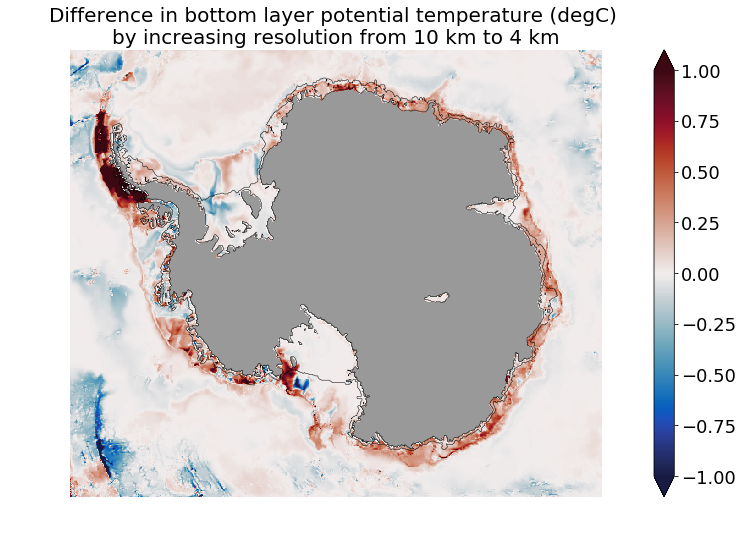

In [36]:
%matplotlib inline
out_path = os.path.join(proj_dir,'reports','figures','10to4temp.png')
plot_temp_map(temp_4,avg10.temp.isel(s_rho=0).mean('ocean_time'),
                   grd10,'by increasing resolution from 10 km to 4 km',
                   out_path = out_path)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


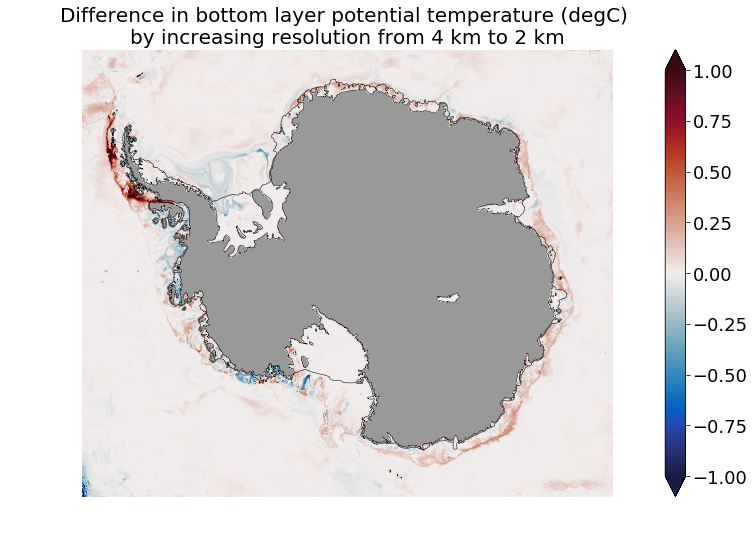

In [37]:
out_path = os.path.join(proj_dir,'reports','figures','4to2temp.png')
plot_temp_map(temp_2,avg4.temp.isel(s_rho=0).mean('ocean_time'),
                   grd4,'by increasing resolution from 4 km to 2 km',
                  out_path = out_path)

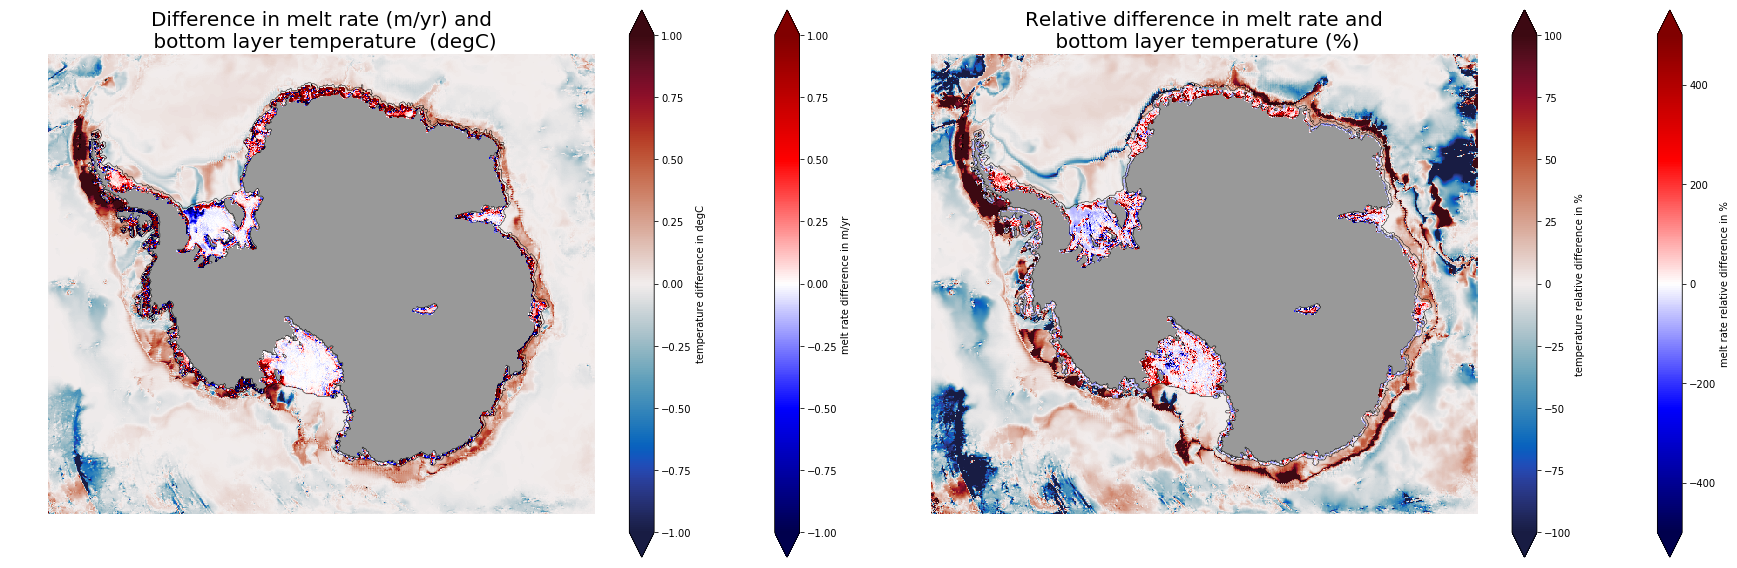

In [145]:
%matplotlib inline
out_path = os.path.join(proj_dir,'reports','figures','res10to4.png')
plot_ismr_temp_map(m_4,avg10.m.mean('ocean_time'),temp_4,avg10.temp.isel(s_rho=0).mean('ocean_time'),
                   grd10,'by increasing resolution from 10 km to 4 km',
                   out_path = out_path)

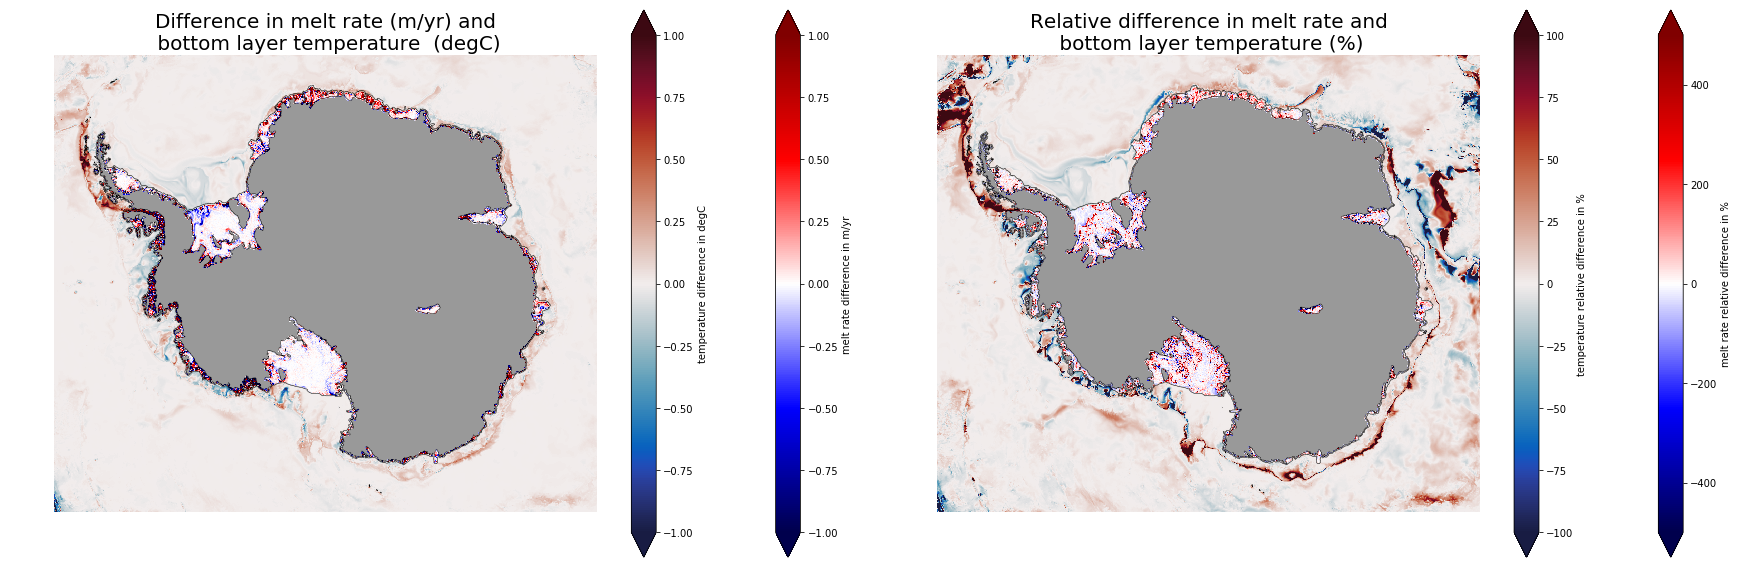

In [150]:
out_path = os.path.join(proj_dir,'reports','figures','res4to2.png')
plot_ismr_temp_map(m_2,avg4.m.mean('ocean_time'),temp_2,avg4.temp.isel(s_rho=0).mean('ocean_time'),
                   grd4,'by increasing resolution from 4 km to 2 km',
                  out_path = out_path)

In [94]:
# %load ../../src/tools/calc_antarctic_mass_loss.py

import xarray as xr

def calc_antarctic_mass_loss(m,grd):
    
    s2a = 3600*24*365.25
    rhoi = 916
    
    ice_shelf = (grd.mask_rho==1) & (grd.zice<0.0) 
    vostock = (grd.lat_rho<-75) & (grd.lat_rho>-80) & (grd.lon_rho>95) & (grd.lon_rho<115)
    
    mask = ice_shelf & ~vostock
    
    dA = (1/(grd.pm*grd.pn)).where(mask)
    weights = dA/dA.sum()
    
    ismr = (m.where(mask)*weights*s2a).sum()
    bmb = (m.where(mask)*dA*rhoi*s2a*10**-12).sum()
    
    print('Area of all ice shelves in 10^3 km^2: ',dA.sum().values*10**-9)
    print('Area average melt rate in m/yr: ',ismr.values)
    print('Basal mass loss in Gt/a: ',bmb.values)
    


In [95]:
calc_antarctic_mass_loss(m_10to4,grd10)

Area of all ice shelves in 10^3 km^2:  1908.8416851122813
Area average melt rate in m/yr:  -0.39043729811067307
Basal mass loss in Gt/a:  -682.679218891537


In [16]:
waom4_his_path = os.path.join(data_dir,'raw','waom4','ocean_avg_0008.nc')
avg4 = xr.open_mfdataset(waom4_his_path)

waom4_grd_path = os.path.join(data_dir,'raw','waom_frc','waom4_grd.nc')
grd4 = xr.open_mfdataset(waom4_grd_path)

In [19]:
waom2_avg_path = os.path.join(data_dir,'raw','waom2_fix','bottom_temp.nc')
avg2 = xr.open_mfdataset(waom2_avg_path)

waom2_grd_path = os.path.join(data_dir,'raw','waom_frc','waom2_grd.nc')
grd2 = xr.open_mfdataset(waom2_grd_path)

In [20]:
temp_2 = regrid(grd2,avg2.temp.isel(s_rho=0).mean('ocean_time'),grd4)
temp_4to2 = temp_2 - avg4.temp.isel(s_rho=0).mean('ocean_time')

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


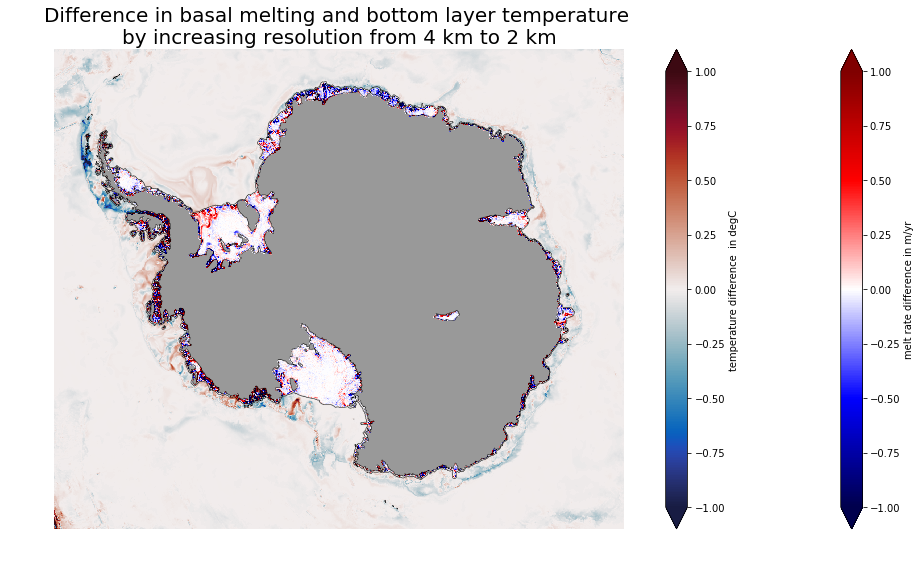

In [90]:
plot_ismr_temp_map(m_4to2,temp_4to2,grd4,'by increasing resolution from 4 km to 2 km')

In [149]:
calc_antarctic_mass_loss(m_4to2,grd4)

Area of all ice shelves in 10^3 km^2:  1690.8425444117272
Area average melt rate in m/yr:  -0.1391855771287541
Basal mass loss in Gt/a:  -215.57226016606234


In [28]:
%matplotlib notebook
m_min = -1
m_max = 6
m_cmap = shiftedColorMap(plt.cm.seismic,midpoint= (1 - m_max/(m_max + abs(m_min))))

temp_min = -2
temp_max = 1

s2a = 3600*24*365.25

def plot_m_bt(m_diff,temp_diff,grd):
    
    #plt.close()
    fig,ax = plt.subplots(figsize=(12,7))
    temp_diff.where((grd.mask_rho==1)&(grd.zice == 0)).plot(
    ax=ax,vmin=temp_min,vmax=temp_max,cmap=ocm.thermal,cbar_kwargs={'label':'temp in degC'})
    (waom.m.where((grd.mask_rho==1)&(grd.zice < 0))*s2a).plot(
    ax=ax,vmin=m_min,vmax=m_max,cmap=m_cmap,cbar_kwargs={'label':'ismr in m/yr'})
    ax.set_aspect('equal')
    ax.set_title(res+' km')
    ax.axis('off')
    ax.set_title('Bottom layer temperatures and melt rates for '+res+' km grid resolution')
    fig.tight_layout()
    #plt.show()

<IPython.core.display.Javascript object>


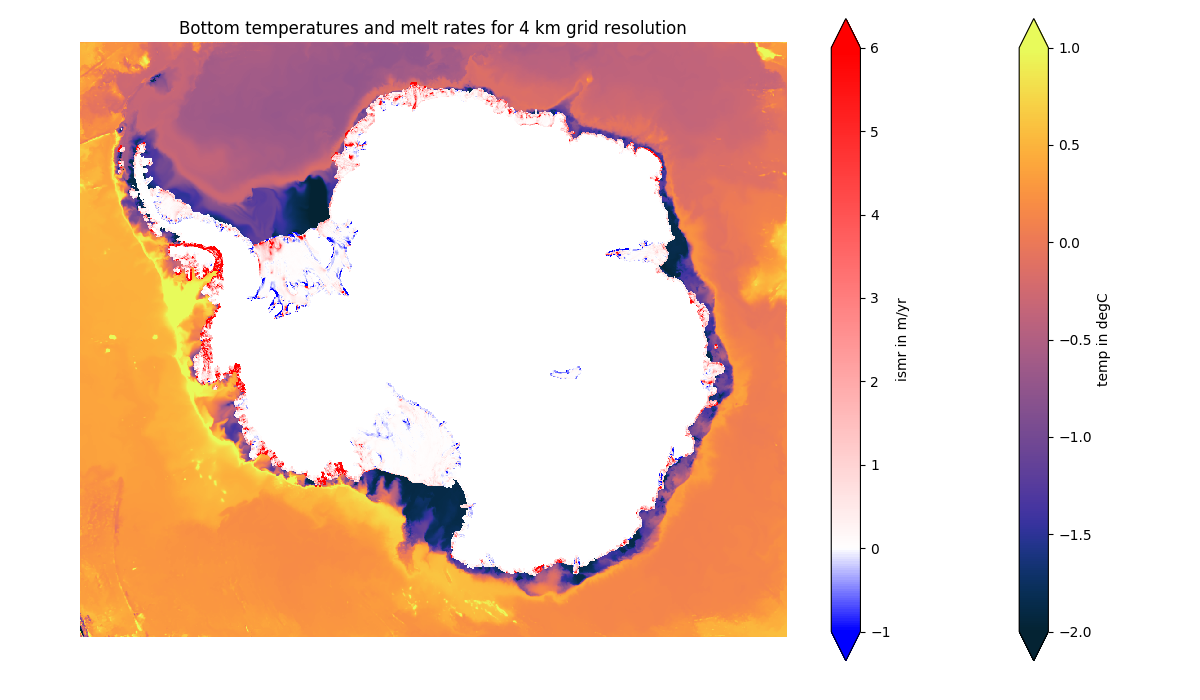

In [29]:
%matplotlib notebook
plot_m_bt(waom4_his,waom4_grd,'4')

<IPython.core.display.Javascript object>


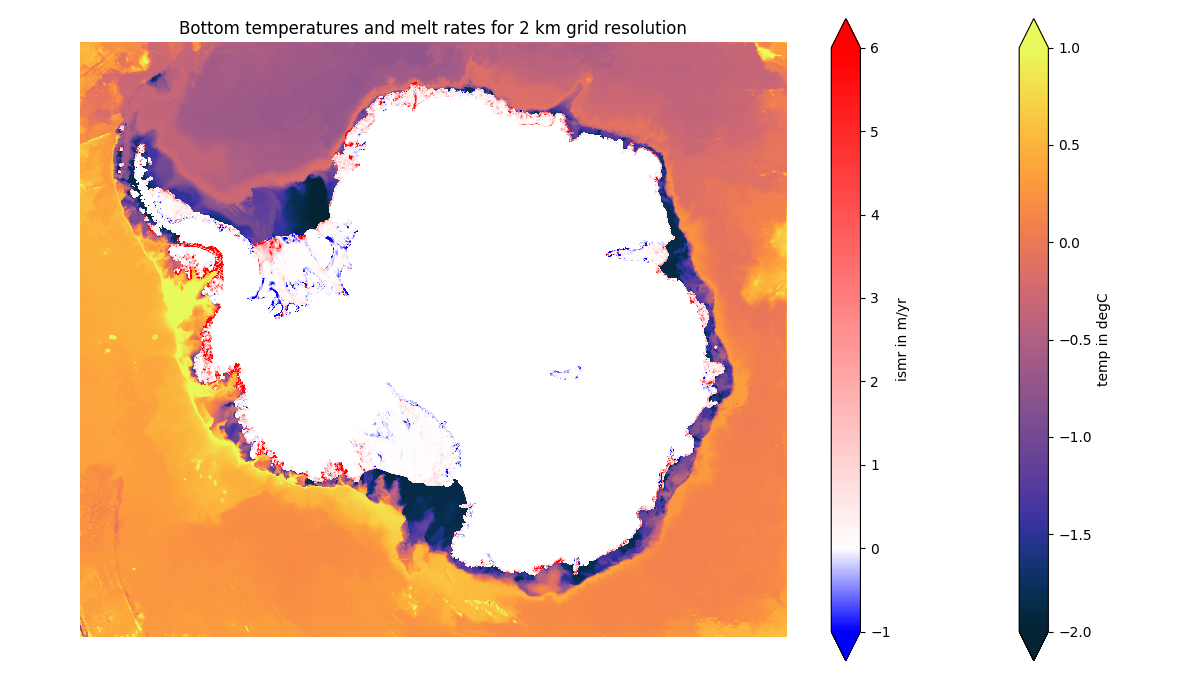

In [30]:
plot_m_bt(waom2_his,waom2_grd,'2')